In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
from get_data import get_adjclose

In [3]:

df = yf.download(tickers = 'BTC-USD', start = '2018-01-01',end ='2023-07-20' )
df = df.drop(columns=['Open','High','Low','Close','Volume'])
df = df.dropna()

[*********************100%%**********************]  1 of 1 completed


In [4]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

In [5]:
data_df = pd.DataFrame(df_scaled, index=df.index, columns=['Adj Close'])


In [6]:
def train_and_evaluate_lstm(data_df, sequence_length):
    # Create sequences for training
    X, y = [], []

    for i in range(len(data_df) - sequence_length):
        X.append(data_df.iloc[i:i+sequence_length, 0].values)
        y.append(data_df.iloc[i+sequence_length, 0])

    X, y = np.array(X), np.array(y)

    # Reshape input data for LSTM (samples, time steps, features)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build the LSTM model
    model_lstm = Sequential()
    model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model_lstm.add(LSTM(units=50))
    model_lstm.add(Dense(units=1))
    model_lstm.compile(optimizer='adam', loss='mean_squared_error')

    # Train the LSTM model
    model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Generate predictions on the test set
    predictions_lstm = model_lstm.predict(X_test)

    

    # Calculate metrics
    mse_lstm = mean_squared_error(y_test, predictions_lstm)
    mae_lstm = mean_absolute_error(y_test, predictions_lstm)
    r2_lstm = r2_score(y_test, predictions_lstm)

    return mse_lstm, mae_lstm, r2_lstm

In [7]:
sequence_lengths = [5, 10, 15, 20, 25, 30 , 35, 40, 45]

In [15]:
maes = []
mses = []
r2s = []
for seq_length in sequence_lengths:
    mse, mae, r2 = train_and_evaluate_lstm(data_df, seq_length)
    # print(f'Sequence Length: {seq_length}')
    # print(f'Mean Squared Error (MSE): {mse}')
    # print(f'Mean Absolute Error (MAE): {mae}')
    # print(f'R-squared (R2): {r2}')
    # print('-' * 50)
    mses.append(mse)
    maes.append(mae)
    r2s.append(r2)

13/13 [==============================] - 1s 6ms/step


<Axes: xlabel='Date'>

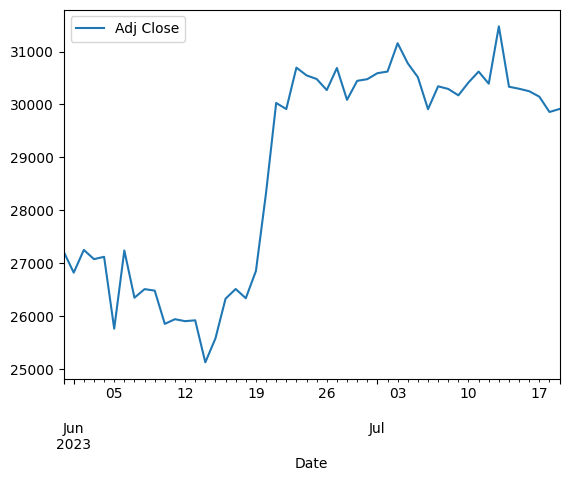

In [9]:
df.iloc[-50:].plot()

In [10]:
import matplotlib.pyplot as plt

In [11]:
mses

[0.0006948594938037163,
 0.0008544622303379948,
 0.0006798834531495356,
 0.0008765375875654278,
 0.0007136202626011774,
 0.0009149538657768799,
 0.0006847798943865941,
 0.0006590977192856755,
 0.000730808369446124]

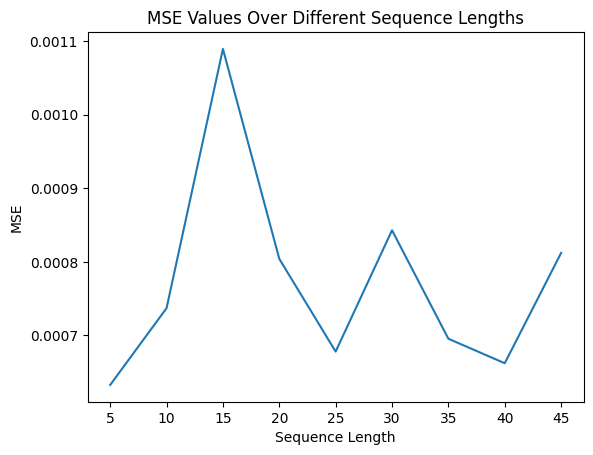

In [16]:

plt.plot(sequence_lengths, mses)

plt.xlabel('Sequence Length')
plt.ylabel('MSE')
plt.title('MSE Values Over Different Sequence Lengths')
plt.show()

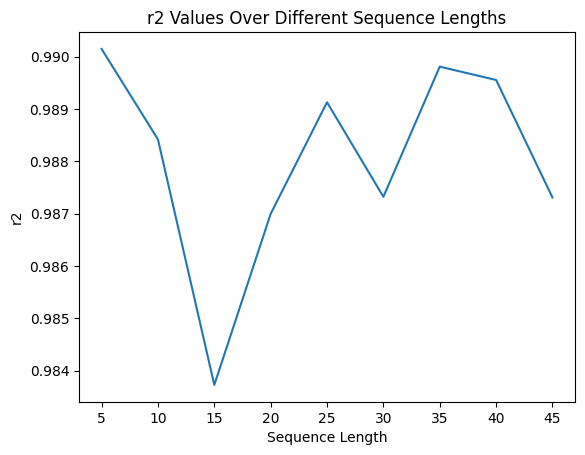

In [17]:

plt.plot(sequence_lengths, r2s)

plt.xlabel('Sequence Length')
plt.ylabel('r2')
plt.title('r2 Values Over Different Sequence Lengths')
plt.show()